# Valet Parking

Calculate new parked positions for non-functional robots. See this [interactive demo](https://observablehq.com/@dkirkby/robot-valet-parking) for details.

### Imports

In [1]:
import pathlib
import itertools
from collections import namedtuple
import json

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm

In [3]:
from scipy.spatial import ConvexHull

In [4]:
import pandas as pd

In [224]:
import astropy.time
import astropy.table

In [6]:
import fpoffline.db
import fpoffline.io
import fpoffline.const
import fpoffline.keepout

Not using DOS logging. Log messages will not be recorded


### Initial Focalplane State

Use an offline snapshot to establish the initial state of the focal plane that we will optimize.

Running at NERSC, you can find the latest snapshot using:
```
import fpoffline.io

snap = fpoffline.io.get_snapshot()
```

Here, we use a fixed version stored in this repo instead. This particular version describes the state of the focalplane just before we implemented the valet parking updates on Tuesday 15 April 2025 and was downloaded from [here](https://data.desi.lbl.gov/desi/engineering/focalplane/calibration/20250410T170059%2B0000_fp_calibs.ecsv):

In [7]:
when = astropy.time.Time('2025-04-11T00:00:00', format='isot', scale='utc')
snap, _ = fpoffline.io.get_snapshot(when, path=pathlib.Path('.'))
assert snap.meta['name'] == '20250410T170059+0000_fp_calibs.ecsv'

Define a helper function to return the snapshot entry for a specified POS_ID:

In [8]:
lookup = { dev['POS_ID']: snap[k] for k, dev in enumerate(snap) }

Look up the calibration data at the time of the snapshot. Almost all of this information is already in the snapshot, except for the flag (`zeno_motor_p`) that identifies recovered linear phi robots (which we need below).

In [9]:
DB = fpoffline.db.DB()

In [10]:
calib = fpoffline.scripts.endofnight.get_calib(DB, at=snap.meta['DATE_RETRIEVED'])
calib.set_index('pos_id', verify_integrity=True, inplace=True)

Loaded 502 calib rows for petal_id 4
Loaded 502 calib rows for petal_id 5
Loaded 502 calib rows for petal_id 6
Loaded 502 calib rows for petal_id 3
Loaded 507 calib rows for petal_id 8
Loaded 506 calib rows for petal_id 10
Loaded 503 calib rows for petal_id 11
Loaded 510 calib rows for petal_id 2
Loaded 502 calib rows for petal_id 7
Loaded 502 calib rows for petal_id 9


Save the calibration actually used:

In [295]:
calib.to_csv('calib-20250410.csv', index=True)

Restore the calibration actually used:

In [ ]:
calib = pd.read_csv('calib-20250410.csv', index_col='pos_id', parse_dates=['time_recorded'])

Lookup useful petal constants:

In [11]:
PTL = fpoffline.const.get_petal_design()

### Positioner Categories

Identify robots that will not have valet parking applied:
 - ETC fiber
 - broken fiber
 - disabled by relay

Create a boolean mask of non-functional robot locations. Finding relayoff robots is relatively slow, so we save the results and you can skip the cell below and just load them instead:

In [125]:
def getSets(calib, at=None, ndays=14):

    # See https://github.com/desihub/fpoffline/blob/main/nb/NonFunctional/NonFunctional.ipynb

    # Identify all non-functional positioners
    is_nonfunc = calib.device_classified_nonfunctional
    nonfunc = set(calib[is_nonfunc].index.to_list())
    # Remove devices that are still in the calib DB but were removed in 2021 shutdown
    removed = set(fpoffline.const.REMOVED_2021)
    nonfunc -= removed
    print(f'Found {len(nonfunc)} non-functional devices')

    # Identify ETC positioners
    is_ETC = np.isin(calib.device_loc, [461, 501])
    ETC = set(calib[is_ETC].index.to_list())
    assert len(ETC - nonfunc) == 0, 'All ETC devices should be non-functional'
    print(f'Found {len(ETC)} ETC devices')

    # Identify non-ETC positioners with broken fibers
    is_badfiber = ~(calib.fiber_intact | is_ETC)
    badfiber = set(calib[is_badfiber].index.to_list())
    assert len(badfiber - nonfunc - removed) == 0, 'All broken fibers should be non-functional'
    print(f'Found {len(badfiber)} broken fibers')

    # Identify positioners with the relayoff bit set.
    # Since this is not recorded in the calib DB, we have to look for the relayoff bit
    # in recent move DB entries for each non-functional device.
    stop = pd.Timestamp(at) or pd.Timestamp.now()
    start = stop - pd.DateOffset(days=ndays)
    when = f"time_recorded>TIMESTAMP '{start}' and time_recorded<=TIMESTAMP '{stop}'"
    print(f'Scanning moves DB for relayoff devices between {start} and {stop}...')
    relayoff = set()
    for petal_loc, petal_id in enumerate(fpoffline.const.PETAL_ID_MAP):
        # Find non-functional devices on this petal.
        petal_calib = calib[(calib.petal_id == petal_id) & is_nonfunc]
        nonfunc_ids = ','.join([f"'{pos_id}'" for pos_id in petal_calib.index])
        table_name = f'posmovedb.positioner_moves_p{petal_id}'
        sql = f'select pos_id,flags from {table_name} where pos_id in ({nonfunc_ids}) and {when}'
        table = DB.query(sql, maxrows=2000)
        # Find the most recent valid flags for each device.
        latest = table[~table['flags'].isna()].groupby('pos_id').last()
        assert np.all(~latest['flags'].isna())
        is_relayoff = latest['flags'].astype(int) & (1<<30) > 0
        noff = np.count_nonzero(is_relayoff)
        ntot = len(latest)
        print(f'  read {len(table)} flags for petal loc[{petal_loc}] with {noff}/{ntot} relay_off')
        relayoff |= set(latest[is_relayoff].index.to_list())
    assert len(relayoff - nonfunc) == 0, 'All relayoff devices should be non-functional'
    assert len(relayoff & ETC) == 0, 'Relayoff devices should not be ETC'
    assert len(relayoff & badfiber) == 0, 'Relayoff devices should not have broken fibers'
    print(f'Found {len(relayoff)} relayoff devices')

    return namedtuple('Categories', 'nonfunc ETC badfiber relayoff')(nonfunc, ETC, badfiber, relayoff)

sets = getSets(calib, at=snap.meta['DATE_RETRIEVED'])

Found 659 non-functional devices
Found 20 ETC devices
Found 22 broken fibers
Scanning moves DB for relayoff devices between 2025-03-27 17:00:49+00:00 and 2025-04-10 17:00:49+00:00...
  read 2000 flags for petal loc[0] with 7/45 relay_off
  read 2000 flags for petal loc[1] with 2/63 relay_off
  read 2000 flags for petal loc[2] with 4/50 relay_off
  read 2000 flags for petal loc[3] with 14/94 relay_off
  read 2000 flags for petal loc[4] with 10/61 relay_off
  read 2000 flags for petal loc[5] with 6/50 relay_off
  read 2000 flags for petal loc[6] with 11/53 relay_off
  read 2000 flags for petal loc[7] with 1/93 relay_off
  read 2000 flags for petal loc[8] with 13/66 relay_off
  read 2000 flags for petal loc[9] with 3/43 relay_off
Found 71 relayoff devices


In [126]:
def saveSets(name='sets-20250410.json'):
    """Save the sets to a JSON file."""
    with open(name, 'w') as f:
        json.dump({
            'nonfunc': list(sets.nonfunc),
            'ETC': list(sets.ETC),
            'badfiber': list(sets.badfiber),
            'relayoff': list(sets.relayoff),
        }, f, indent=2)
    print(f'Saved sets to {name}')

saveSets()

Saved sets to sets-20250410.json


In [12]:
def loadSets(name='sets-20250410.json'):
    """Load the sets from a JSON file."""
    with open(name, 'r') as f:
        data = json.load(f)
    return namedtuple('Categories', 'nonfunc ETC badfiber relayoff')(
        set(data['nonfunc']),
        set(data['ETC']),
        set(data['badfiber']),
        set(data['relayoff']),
    )

Run this cell instead of the slower `getSets()` above to save time:

In [13]:
sets = loadSets('sets-20250410.json')

In [14]:
def getMaskForPosIDs(pos_ids):
    mask = np.zeros((10, 514), bool)
    for pos_id in pos_ids:
        dev = calib.loc[pos_id]
        petal_loc = fpoffline.const.PETAL_ID_MAP.index(dev.petal_id)
        mask[petal_loc, PTL.locmap[dev.device_loc]] = True
    return mask

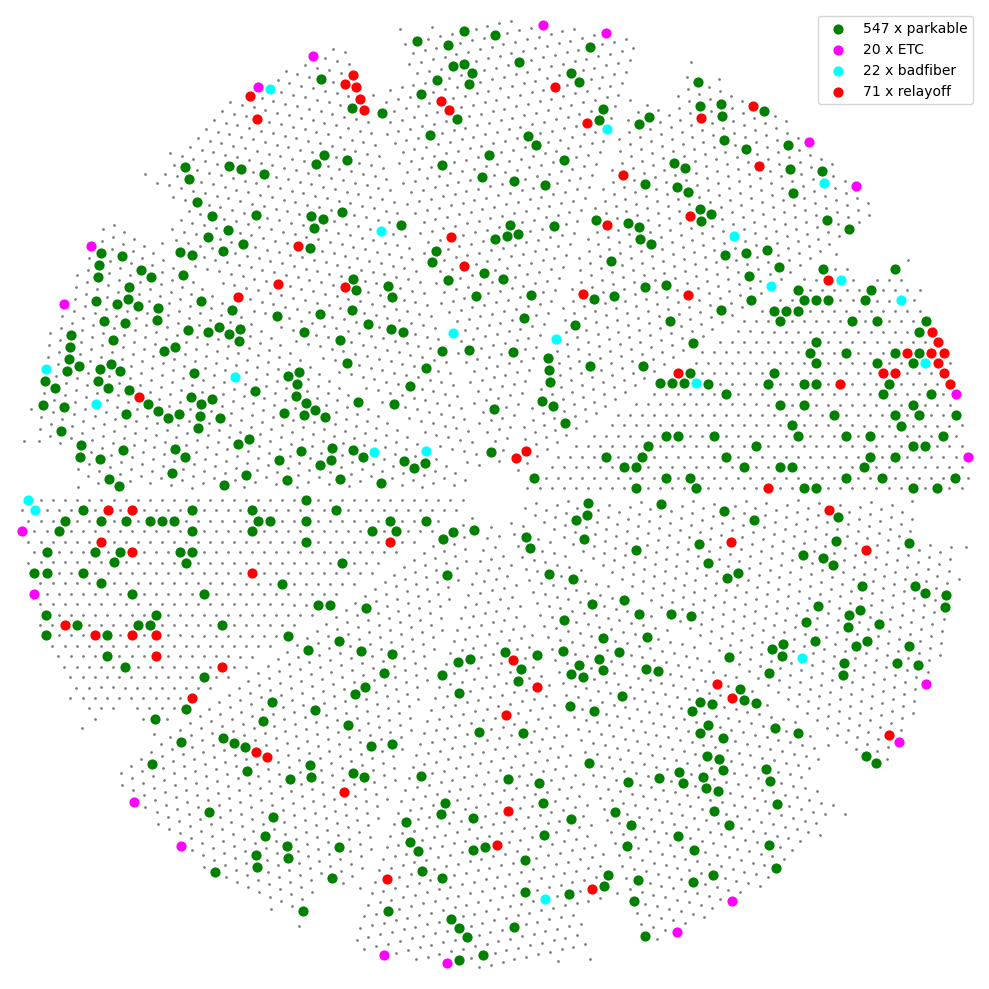

In [15]:
def plotSets():

    fig, ax = plt.subplots(figsize=(10, 10))

    ax.scatter(PTL.xfp, PTL.yfp, s=1, c='gray')

    parkable = sets.nonfunc - sets.ETC - sets.badfiber - sets.relayoff
    colors = {'parkable': 'green', 'ETC': 'magenta', 'badfiber': 'cyan', 'relayoff': 'red'}
    for name in ('parkable', 'ETC', 'badfiber', 'relayoff'):
        pos_ids = getattr(sets, name) if name != 'parkable' else parkable
        mask = getMaskForPosIDs(pos_ids)
        color = colors[name]
        ax.scatter(PTL.xfp[mask], PTL.yfp[mask], s=40, c=color, label=f'{len(pos_ids)} x {name}')

    ax.legend()
    ax.set(xlim=(-420,420), ylim=(-420, 420), aspect=1)
    ax.axis('off')
    plt.tight_layout()
    plt.savefig('sets-20250410.png')

plotSets()

### Find Non-Overlapping Groups of Parkable Robots

In [16]:
def findGroups():

    visited = set()
    parkable = sets.nonfunc - sets.ETC - sets.badfiber - sets.relayoff

    def visit(dev, group):
        pos_id = dev['POS_ID']
        group.add(pos_id)
        if pos_id in parkable:
            visited.add(pos_id)
            for neighbor in dev['POS_NEIGHBORS']:
                if neighbor not in visited:
                    visit(lookup[neighbor], group)
        return group

    found = []
    for k, dev in enumerate(snap):
        pos_id = dev['POS_ID']
        if pos_id not in visited and pos_id in parkable:
            found.append(list(visit(dev, set())))

    groups = []
    for group in found:
        func, nonfunc, topark = [], [], []
        for pos_id in group:
            if pos_id in sets.nonfunc:
                nonfunc.append(pos_id)
                if pos_id in parkable:
                    topark.append(pos_id)
            else:
                func.append(pos_id)
        groups.append(namedtuple('Group', 'func nonfunc parkable')(func, nonfunc, topark))

    return groups

In [18]:
groups = findGroups()
print(f'Found {len(groups)} groups of parkable devices')

Found 383 groups of parkable devices


In [72]:
def findGroup(pos_id):
    """Find the group of parkable devices that contains the given positioner."""
    for group in groups:
        if pos_id in group.nonfunc + group.func:
            return group
    return None

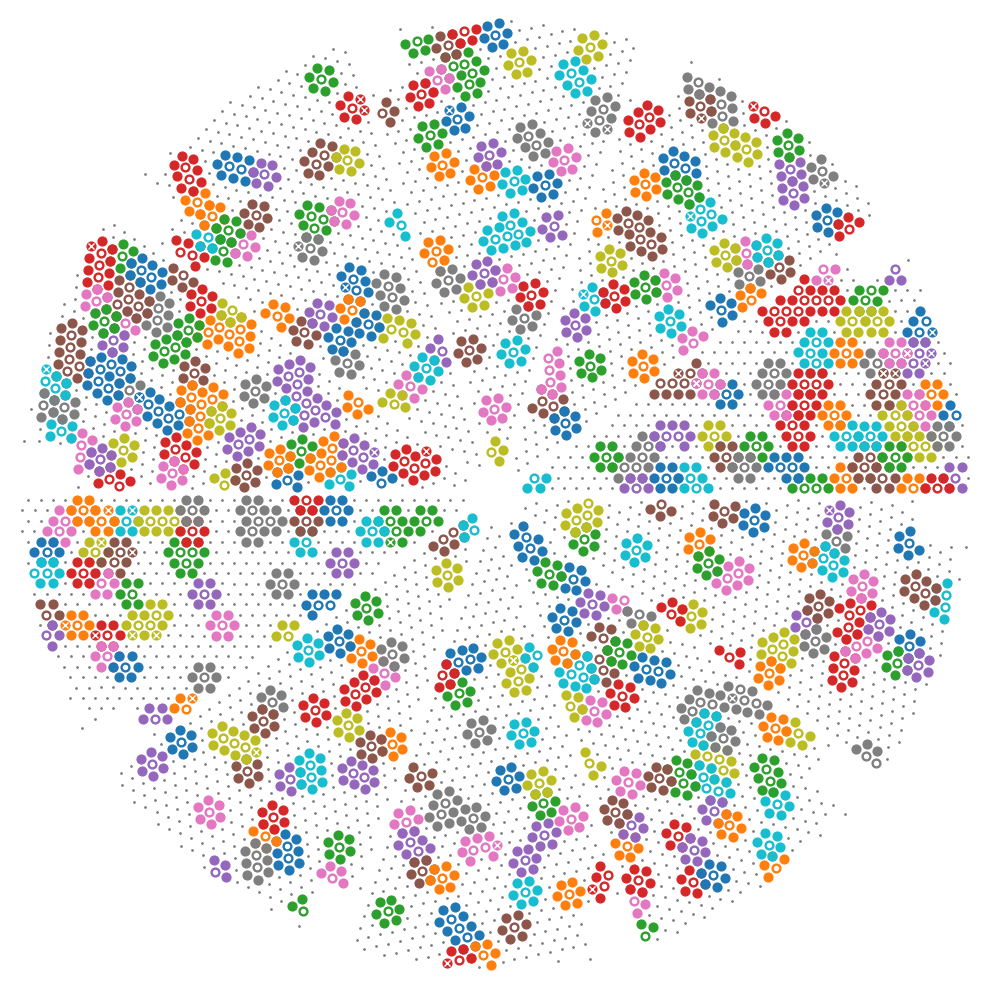

In [19]:
def plotGroups():

    fig, ax = plt.subplots(figsize=(10, 10))

    ax.scatter(PTL.xfp, PTL.yfp, s=1, c='gray')

    cmap = plt.get_cmap('tab10')
    for k, group in enumerate(groups):
        color = cmap(k % 10)
        mask = getMaskForPosIDs(set(group.func) | set(group.nonfunc))
        ax.scatter(PTL.xfp[mask], PTL.yfp[mask], s=40, color=color)
        mask = getMaskForPosIDs(set(group.parkable))
        ax.scatter(PTL.xfp[mask], PTL.yfp[mask], s=15, lw=0, color='w')
        mask = getMaskForPosIDs(set(group.nonfunc) - set(group.parkable))
        ax.plot(PTL.xfp[mask], PTL.yfp[mask], 'wx', ms=4, lw=2)

    ax.set(xlim=(-420,420), ylim=(-420, 420), aspect=1)
    ax.axis('off')
    plt.tight_layout()
    plt.savefig('groups-20250410.png')

plotGroups()

### Keepout Polygons Calculations

Each robot has a keepout polygon defined for its theta and phi arms. See [this notebook](https://github.com/desihub/fpoffline/blob/main/nb/Keepouts/Keepouts.ipynb) for details.

First, verify that the computed polygons stored in the snapshot match what we calculate from the calibration data:

In [21]:
def verifyKeepouts():

    badT, badP = [ ], [ ]
    for dev in snap:
        poly_T1, poly_P1 = fpoffline.keepout.adjusted_keepouts_from_snapshot(snap, dev['POS_ID'])
        poly_T2, poly_P2 = fpoffline.keepout.adjusted_keepouts_from_calib(calib, dev['POS_ID'])
        if not np.allclose(poly_T1, np.round(poly_T2, 5)):
            badT.append(dev['POS_ID'])
        if not np.allclose(poly_P1, np.round(poly_P2, 5)):
            badP.append(dev['POS_ID'])
    print('badT', len(badT), ','.join(badT))
    print('badP', len(badP), ','.join(badP))

verifyKeepouts()

badT 0 
badP 0 


Next, generate the keepout to use for each robot. The DESI keepouts are slightly non-convex, so we make them convex (by taking the convex hull) for more efficient overlap tests. We also use the convention that polygons are stored in arrays of shape (N,2) instead of a pair of arrays of shape (N,) as used in `fpoffline.keepout`.

In [22]:
def getConvexHull(x, y):
    """Calculate the convex hull and convert from (N,)+(N,) to (M,2)."""
    pts = np.array([x, y]).T
    hull = ConvexHull(pts)
    return pts[hull.vertices]

In [ ]:
def getKeepouts():

    keepouts = { }
    for dev in snap:
        pos_id = dev['POS_ID']
        (polyTx,polyTy), (polyPx,polyPy) = fpoffline.keepout.adjusted_keepouts_from_calib(calib, pos_id)
        # Calculate convex hulls.
        polyT = getConvexHull(polyTx, polyTy)
        polyP = getConvexHull(polyPx, polyPy)
        keepouts[pos_id] = ( polyT, polyP )
    return keepouts

keepouts = getKeepouts()

The first step of "valet parking" is to reset the keepouts for non-functional robots, by settting any radial or angular expansion parameters to zero. A complication is that the petal code applies a minimum 5° angular expansion of the phi keepout for all recovered linear phi robots (i.e. with `zeno_motor_p = True`). This is applied on the fly, independent of the `KEEPOUT_EXPANSION_PHI_ANGULAR` calibration parameter, but included in the polygons calculated by [poscollider.pyx](https://desi.lbl.gov/trac/browser/code/focalplane/plate_control/branches/kpnolinphi/petal/poscollider.pyx) and used by fiber assignment. See [here](https://github.com/desihub/fpoffline/blob/main/nb/Keepouts/Keepouts.ipynb) for details.

In [127]:
def getResetKeepouts():

    updates = [ ]
    reset_keepouts = { }
    for pos_id in sets.nonfunc:
        # Lookup the calib params that contribute to the keepout used by fiber assignment.
        dev = calib.loc[pos_id]
        dR_T = dev.keepout_expansion_theta_radial
        dA_T = dev.keepout_expansion_theta_angular
        dR_P = dev.keepout_expansion_phi_radial
        dA_P = dev.keepout_expansion_phi_angular
        R1 = dev.length_r1
        R2 = dev.length_r2
        is_linphi = dev.zeno_motor_p == True

        if dR_T != 0.0 or dA_T != 0.0 or dR_P != 0.0 or dA_P != 0.0:
            # Set the keepout expansion params all to zero.
            # Note that this won't actually change the keepout for recovered linphis with dA_P < 5.
            updates.append(dict(POS_ID=pos_id,
                                KEEPOUT_EXPANSION_THETA_RADIAL=0.0, KEEPOUT_EXPANSION_THETA_ANGULAR=0.0,
                                KEEPOUT_EXPANSION_PHI_RADIAL=0.0, KEEPOUT_EXPANSION_PHI_ANGULAR=0.0,
                                COMMIT_KEEPOUT_EXPANSION_THETA_RADIAL=True,
                                COMMIT_KEEPOUT_EXPANSION_THETA_ANGULAR=True,
                                COMMIT_KEEPOUT_EXPANSION_PHI_RADIAL=True,
                                COMMIT_KEEPOUT_EXPANSION_PHI_ANGULAR=True))
            # Calculate the updated keepouts.
            (polyTx,polyTy), (polyPx,polyPy) = fpoffline.keepout.adjusted_keepouts(
                0, 0, 0, 0, R1, R2, is_linphi)
            # Calculate convex hulls.
            polyT = getConvexHull(polyTx, polyTy)
            polyP = getConvexHull(polyPx, polyPy)
            # Compare with the original keepouts.
            sameT = np.allclose(np.round(polyT, 5), np.round(keepouts[pos_id][0], 5))
            sameP = np.allclose(np.round(polyP, 5), np.round(keepouts[pos_id][1], 5))
            if sameT and (dR_T != 0 or dA_T != 0):
                print(f'{pos_id} same keepoutT with {dR_T},{dA_T},{dR_P},{dA_P},{is_linphi}')
            if sameP and (dR_P != 0 or dA_P != 5):
                print(f'{pos_id} same keepoutP with {dR_T},{dA_T},{dR_P},{dA_P},{is_linphi}')
            # Save the updated keepouts.
            reset_keepouts[pos_id] = ( polyT, polyP )

    print(f'Reset keepout params for {len(reset_keepouts)} / {len(sets.nonfunc)} non-functional devices')

    updates = pd.DataFrame(updates)
    updates.to_csv('reset_nonfunc_keepout_calib.csv', index=False)

    return reset_keepouts

In [128]:
reset_keepouts = getResetKeepouts()

Reset keepout params for 138 / 659 non-functional devices


Implement a utility function that returns the keepouts for pos_id that are positioned in petal coords for specified angles (T,P). Uses the calibration for the positioner's origin (OFFSET_X,OFFSET_Y) and theta arm length (LENGTH_R1).

Note that **angles must be in radians** and should be external, i.e. with OFFSET_T/P already added to the internal angles.

The result is a tuple with shapes (n,2) and (m,2) when (T,P) are scalars. If T,P are 1D arrays of length N, the calculation is vectorized and the result is a tuple with shapes (N,n,2) and (N,m,2).

When `reset=True`, uses the `reset_keepouts` defined above when it is available.

In [58]:
def getRotatedKeepouts(posid, T, P, reset=False):
    """T,P must be input in radians!
    """
    T = np.asarray(T)
    P = np.asarray(P)
    assert np.all(np.abs(T) <= 2 * np.pi), 'T must be in radians'
    assert T.shape == P.shape, 'T and P must have the same shape'
    assert T.ndim <= 1, 'T and P must be scalars or 1D arrays'
    scalar = T.ndim == 0
    if scalar:
        T = np.array([T])
        P = np.array([P])

    if reset and posid in reset_keepouts:
        polyT, polyP = reset_keepouts[posid]
    else:
        polyT, polyP = keepouts[posid]

    cosT, sinT = np.cos(T), np.sin(T)
    cosTP, sinTP = np.cos(T + P), np.sin(T + P)

    if posid not in calib.index:
        raise ValueError(f'Positioner {posid} not found in calib.index')
    dev = calib.loc[posid]
    x0, y0 = float(dev.offset_x), float(dev.offset_y)
    r1 = float(dev.length_r1)
    x1, y1 = x0 + r1 * cosT, y0 + r1 * sinT

    RT = np.array(((cosT, -sinT), (sinT, cosT)))
    keepoutT = np.einsum('ijn,mj->nmi', RT, polyT) + np.array([x0, y0])

    RTP = np.array(((cosTP, -sinTP), (sinTP, cosTP)))
    keepoutP = np.einsum('ijn,mj->nmi', RTP, polyP) + np.array([x1,y1]).T.reshape(-1, 1, 2)

    if scalar:
        keepoutT = keepoutT.reshape(-1, 2)
        keepoutP = keepoutP.reshape(-1, 2)

    return keepoutT, keepoutP

Implement efficient convex polygon overlap test where polygon is specified as an array of shape (n,2):

In [65]:
def get_axes(polygon):
    edges = polygon - np.roll(polygon, -1, axis=0)
    normals = np.stack([-edges[:,1], edges[:,0]], axis=-1)
    return normals / np.linalg.norm(normals, axis=-1, keepdims=True)

def project_polygon(polygon, axes):
    projections = np.dot(polygon, axes.T)
    return np.min(projections, axis=0), np.max(projections, axis=0)

def polygons_overlap_sat(poly1, poly2):
    axes = np.vstack((get_axes(poly1), get_axes(poly2)))
    axes /= np.linalg.norm(axes, axis=1, keepdims=True)
    min1, max1 = project_polygon(poly1, axes)
    min2, max2 = project_polygon(poly2, axes)
    if np.any(max1 < min2) or np.any(max2 < min1):
        return False
    return True

Calculate the matrix of overlaps between two lists of polygons. If the input lists have shapes (N,n,2) and (M,m,2), the output matrix has shape (N,M). Note that we are assuming the polygons in each list have the name number of vertices (n and m). Uses bounding-box tests to minimize the number of calls to the more expensive `polygons_overlap_sat()` method.

In [66]:
def getCollisionMatrix(poly1, poly2):
    """Given two lists of convex polygons with shapes (N,n,2) and (M,m,2), calculate the (N,M) collision matrix.
    Result is True if there is a collision.
    """
    # Compute bounding boxes
    min1, max1 = np.min(poly1, axis=1), np.max(poly1, axis=1)
    min2, max2 = np.min(poly2, axis=1), np.max(poly2, axis=1)

    # Calculate (N,M) matrix of bounding box overlaps
    bbox_mask = np.all(max1[:, None, :] >= min2[None, :, :], axis=2) & np.all(max2[None, :, :] >= min1[:, None, :], axis=2)

    collided = np.zeros(bbox_mask.shape, bool)
    for i, j in np.argwhere(bbox_mask):
        if polygons_overlap_sat(poly1[i], poly2[j]):
            collided[i, j] = True

    return collided

In [179]:
def isCollided(polyT, polyP):
    """Check if any pair of robots is collided.
    polyT, polyP must be (N,2) arrays of polygons.
    Returns a symmetric (N,N) boolean array of collisions
    The diagonal is set to False (self collisions) so you
    can use np.any() to test for any non-self collisions.
    """
    assert len(polyT) == len(polyP), 'polyT and polyP must have the same number of polygons'
    assert polyT.ndim == 3 and polyP.ndim == 3, 'polyT and polyP must be 3D arrays'
    assert polyT.shape[2] == 2 and polyP.shape[2] == 2, 'polyT and polyP must have shapes (N,n,2) and (N,m,2)'
    N = polyT.shape[0]
    collidedTP = getCollisionMatrix(polyT, polyP)
    collidedPT = getCollisionMatrix(polyP, polyT)
    collidedPP = getCollisionMatrix(polyP, polyP)
    collided = collidedTP | collidedPT | collidedPP
    # Remove self-collisions
    collided[np.eye(N, dtype=bool)] = False
    return collided

[[False  True]
 [ True False]]


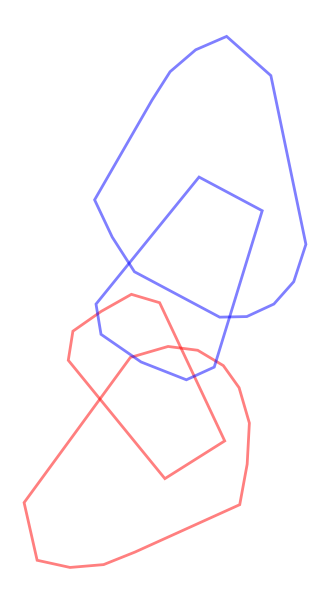

In [180]:
def testIsCollided():

    dev1 = calib.loc['M02721']
    polyT1, polyP1 = getRotatedKeepouts('M02721', np.deg2rad(-54 + dev1.offset_t), np.deg2rad(106))
    dev2 = calib.loc['M01956']
    polyT2, polyP2 = getRotatedKeepouts('M01956', np.deg2rad(-98 + dev2.offset_t), np.deg2rad(0))

    fig, ax = plt.subplots(figsize=(4, 8))
    ax.fill(*polyT1.T, fc='none', ec='r', alpha=0.5, lw=2)
    ax.fill(*polyP1.T, fc='none', ec='r', alpha=0.5, lw=2)
    ax.fill(*polyT2.T, fc='none', ec='b', alpha=0.5, lw=2)
    ax.fill(*polyP2.T, fc='none', ec='b', alpha=0.5, lw=2)
    ax.set(aspect=1)
    ax.axis('off')

    print(isCollided(np.array([polyT1, polyT2]), np.array([polyP1, polyP2])))

testIsCollided()

### Tuck Parkable Robots

In [283]:
phiTuckRange = (155, 165)

Robots will be tucked in phi using the PECS [move_to_range.py](https://desi.lbl.gov/trac/browser/code/focalplane/plate_control/trunk/pecs/move_to_range.py) script:
```
python -m move_to_range --prepark None --mode poslocTP --anticollision None -pu 155 -pl 165 -iter 10
```

relayoff M05211 is low at 150.4
relayoff M04585 is low at 108.8
relayoff M04569 is low at 150.1
relayoff M04056 is low at 150.1
relayoff M06280 is low at 149.7
relayoff M06182 is low at 150.3
ETC M04529 is low at 131.3
badfiber M03493 is low at 130.1
ETC M06214 is low at 119.4
relayoff M07357 is low at 150.3
badfiber M03599 is low at 147.4
relayoff M06054 is low at 136.4
relayoff M04263 is low at 149.9
relayoff M05957 is low at 149.6
relayoff M06979 is low at 149.9
badfiber M01381 is low at 146.3
relayoff M03125 is low at 152.3
relayoff M05036 is low at 149.8
ETC M02956 is low at 134.1
badfiber M07163 is low at 146.3
relayoff M06585 is low at 151.7
ETC M01727 is low at 144.6
relayoff M01690 is low at 140.4
relayoff M07411 is low at 150.3
ETC M04133 is low at 143.8
relayoff M01706 is low at 150.5
relayoff M05766 is low at 138.2
relayoff M06153 is low at 152.6
relayoff M03028 is low at 150.4
ETC M07601 is low at 143.6
relayoff M04039 is low at 150.9
relayoff M06739 is low at 150.2
relayo

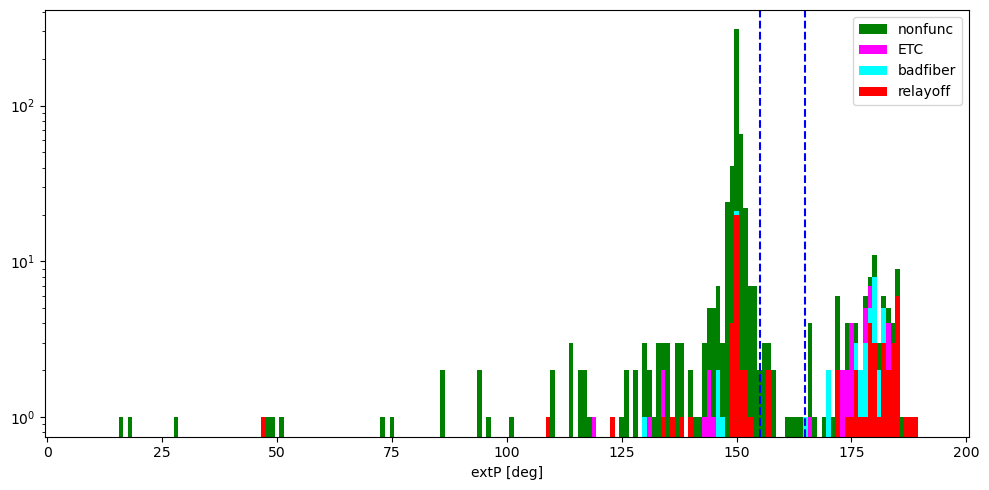

In [284]:
def getTucks():

    to_tuck = [ ]
    extPnonfunc, extPetc, extPbadfiber, extPrelayoff = [], [], [], []
    for posid in sets.nonfunc:
        dev = lookup[posid]
        extP = dev['OFFSET_P'] + dev['POS_P']
        is_low = extP < phiTuckRange[0]
        extPnonfunc.append(extP)
        if posid in sets.ETC:
            extPetc.append(extP)
            if is_low:
                print(f'ETC {posid} is low at {extP:.1f}')
        elif posid in sets.badfiber:
            extPbadfiber.append(extP)
            if is_low:
                print(f'badfiber {posid} is low at {extP:.1f}')
        elif posid in sets.relayoff:
            extPrelayoff.append(extP)
            if is_low:
                print(f'relayoff {posid} is low at {extP:.1f}')
        else:
            # parkable
            if is_low:
                to_tuck.append(posid)

    bins = np.linspace(-0.5, 200.5, 202)
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.hist(extPnonfunc, bins=bins, histtype='stepfilled', color='green', label='nonfunc')
    ax.hist(extPetc+extPbadfiber+extPrelayoff, bins=bins, histtype='stepfilled', color='magenta', label='ETC')
    ax.hist(extPbadfiber+extPrelayoff, bins=bins, histtype='stepfilled', color='cyan', label='badfiber')
    ax.hist(extPrelayoff, bins=bins, histtype='stepfilled', color='red', label='relayoff')
    ax.legend()
    ax.set(xlabel='extP [deg]', yscale='log', xlim=bins[[0,-1]])
    ax.axvline(phiTuckRange[0], color='b', ls='--')
    ax.axvline(phiTuckRange[1], color='b', ls='--')
    plt.tight_layout()
    plt.savefig('phi-tucks.png')

    print(f'# {len(to_tuck)} parkable robots to tuck in phi using move_to_range:')
    print(','.join(sorted(to_tuck)))
    return to_tuck

to_tuck = getTucks()

In [251]:
def loadMoves(name='snapshot.csv'):

    df = pd.read_csv(name, index_col='pos_id')
    # Check that we have a position for all parkable robots
    parkable = list(sets.nonfunc - sets.ETC - sets.badfiber - sets.relayoff)
    df = df.loc[parkable]
    missing = set(parkable) - set(df.index)
    if missing:
        print(f'Warning: {len(missing)} parkable robots not found in {name}!')
        print(','.join(sorted(missing)))
    return df

M01484 150.0 -> 150.0
M03478 150.2 -> 150.2
M03119 150.1 -> 150.1
M03133 150.2 -> 150.2
M02284 128.2 -> 128.2
M07747 150.2 -> 150.2
M03940  85.9 ->  85.9
M06826 151.2 -> 151.2
M05052 149.6 -> 149.6
M02712 150.0 -> 150.0
M03409 150.4 -> 150.4
M05570 150.0 -> 150.0
M06986 150.1 -> 150.1
M03711 150.3 -> 150.3
M03641 145.8 -> 145.8
M03944 150.4 -> 150.4
M05055 142.2 -> 142.2
M05857 150.0 -> 150.0
M03230 149.7 -> 149.7
M03146 152.2 -> 152.2
M03075 150.0 -> 150.0
M03346 150.4 -> 150.4
M07656 153.8 -> 153.8
M07371 149.1 -> 149.1
M02273 151.3 -> 151.3
M03163 150.3 -> 150.3
M03315 150.1 -> 150.1
M03148 150.3 -> 150.3
M03947 150.8 -> 150.8
M04990 149.8 -> 149.8
M03186 150.2 -> 150.2
M06723 150.1 -> 150.1
M03887 150.0 -> 150.0
M08221 150.4 -> 150.4
M03698 131.4 -> 131.4
M03587 150.3 -> 150.3
M03784 148.8 -> 148.8
M03242 150.5 -> 150.5
M03392 150.1 -> 150.1
M04062 146.5 -> 146.5
M04060 110.1 -> 110.1
M07377 138.0 -> 138.0
M03659 150.1 -> 150.1
M01613 150.4 -> 150.4
M05658  86.3 ->  86.3
M04354 150

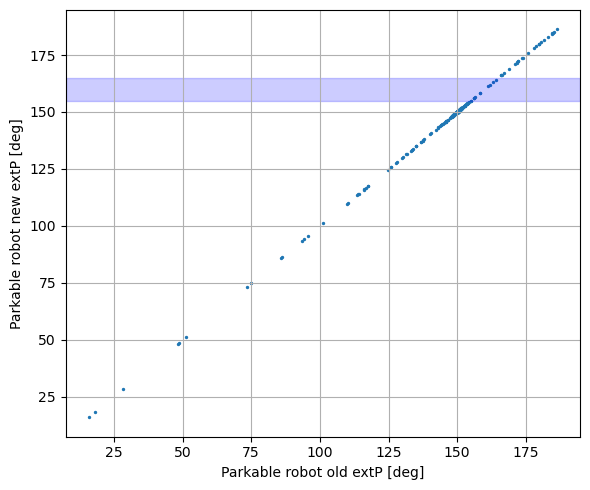

In [287]:
def tuckPlot(now='test-snap.csv', doprint=True, save=None):

    df = loadMoves(now)
    old_extP, new_extP = [], []
    parkable = list(sets.nonfunc - sets.ETC - sets.badfiber - sets.relayoff)
    for posid in parkable:
        dev = lookup[posid]
        old_extP.append(dev['OFFSET_P'] + dev['POS_P'])
        new_extP.append(dev['OFFSET_P'] + df.loc[posid, 'pos_p'])

    old_extP = np.array(old_extP)
    new_extP = np.array(new_extP)

    to_tuck = (old_extP < phiTuckRange[0])
    bad = to_tuck & ((new_extP < phiTuckRange[0]) | (new_extP > phiTuckRange[1]))
    if doprint:
        for k in np.where(bad)[0]:
            print(f'{parkable[k]} {old_extP[k]:5.1f} -> {new_extP[k]:5.1f}')
    print(f'{bad.sum()} / {to_tuck.sum()} parkable robots are out of range after tuck')

    fig, ax = plt.subplots(figsize=(6, 5))
    ax.scatter(old_extP, new_extP, s=2)
    ax.set(xlabel='Parkable robot old extP [deg]', ylabel='Parkable robot new extP [deg]')
    ax.axhspan(*phiTuckRange, color='b', alpha=0.2)
    ax.grid()

    plt.tight_layout()
    if save:
        plt.savefig(save)

tuckPlot(doprint=True)

### Set Status Bits

The DEVICE_CLASSIFIED_NONFUNCTIONAL and CTRL_ENABLED status bits need to be changed *after* running FP setup and before the phi tucks and theta spins, then *restored* before running the spots scripts. We use the `set_operability` command. I am not sure how many posids can be listed in a single command, so this is a parameter (n) below.

In [243]:
def setStatus(setup=True, n=16):

    # Group parkable robots by petal
    parkable = list(sets.nonfunc - sets.ETC - sets.badfiber - sets.relayoff)
    petal_id = calib.loc[parkable].petal_id
    comment = "Prepare for Valet parking" if setup else "Cleanup after Valet parking"
    for petal_loc in range(10):
        sel = petal_id == fpoffline.const.PETAL_ID_MAP[petal_loc]
        pos_ids = petal_id[sel].index.to_list()
        print(f'select PETAL{petal_loc}')
        for offset in range(0, len(pos_ids), n):
            IDs = ",".join(pos_ids[offset:offset+n])
            print(f'set_operability ids={IDs} key=DEVICE_CLASSIFIED_NONFUNCTIONAL value={not setup} comment="{comment}"')
            print(f'set_operability ids={IDs} key=CTRL_ENABLED value={setup} comment="{comment}"')

In [312]:
setStatus(True)

select PETAL0
set_operability ids=M03641,M07371,M04062,M07955,M03168,M05928,M07525,M05914,M08015,M06612,M03090,M05934,M07843,M07499,M03818,M07367 key=DEVICE_CLASSIFIED_NONFUNCTIONAL value=False comment="Prepare for Valet parking"
set_operability ids=M03641,M07371,M04062,M07955,M03168,M05928,M07525,M05914,M08015,M06612,M03090,M05934,M07843,M07499,M03818,M07367 key=CTRL_ENABLED value=True comment="Prepare for Valet parking"
set_operability ids=M08143,M07741,M06666,M07801,M05982,M05829,M07737,M07498,M06768,M07403,M05703,M07364,M07332,M05882,M04015,M07365 key=DEVICE_CLASSIFIED_NONFUNCTIONAL value=False comment="Prepare for Valet parking"
set_operability ids=M08143,M07741,M06666,M07801,M05982,M05829,M07737,M07498,M06768,M07403,M05703,M07364,M07332,M05882,M04015,M07365 key=CTRL_ENABLED value=True comment="Prepare for Valet parking"
set_operability ids=M04515,M05831,M04635,M07502,M06080,M04385 key=DEVICE_CLASSIFIED_NONFUNCTIONAL value=False comment="Prepare for Valet parking"
set_operability 

In [313]:
setStatus(False)

select PETAL0
set_operability ids=M03641,M07371,M04062,M07955,M03168,M05928,M07525,M05914,M08015,M06612,M03090,M05934,M07843,M07499,M03818,M07367 key=DEVICE_CLASSIFIED_NONFUNCTIONAL value=True comment="Cleanup after Valet parking"
set_operability ids=M03641,M07371,M04062,M07955,M03168,M05928,M07525,M05914,M08015,M06612,M03090,M05934,M07843,M07499,M03818,M07367 key=CTRL_ENABLED value=False comment="Cleanup after Valet parking"
set_operability ids=M08143,M07741,M06666,M07801,M05982,M05829,M07737,M07498,M06768,M07403,M05703,M07364,M07332,M05882,M04015,M07365 key=DEVICE_CLASSIFIED_NONFUNCTIONAL value=True comment="Cleanup after Valet parking"
set_operability ids=M08143,M07741,M06666,M07801,M05982,M05829,M07737,M07498,M06768,M07403,M05703,M07364,M07332,M05882,M04015,M07365 key=CTRL_ENABLED value=False comment="Cleanup after Valet parking"
set_operability ids=M04515,M05831,M04635,M07502,M06080,M04385 key=DEVICE_CLASSIFIED_NONFUNCTIONAL value=True comment="Cleanup after Valet parking"
set_ope

### Calculate Accessible Patrol Areas

Initialize a 2D grid of points covering the patrol radii of functional robots in a group. These will be used to calculate (and reduce) the area that is blocked by the non-functional robots in the group.

In [28]:
def initGrid(group, gridDensity=2, gridPad=6):

    # Get the extent of (x,y) centers for this group's functional robots
    xc = np.array([ lookup[posid]['OFFSET_X'] for posid in group.func ])
    yc = np.array([ lookup[posid]['OFFSET_Y'] for posid in group.func ])
    xlo, xhi = xc.min(), xc.max()
    ylo, yhi = yc.min(), yc.max()

    # Add padding in mm
    xlo -= gridPad
    xhi += gridPad
    ylo -= gridPad
    yhi += gridPad

    # Cover the padded region with a uniform grid of at least the specified density (in grid points per mm)
    spacing = 1 / gridDensity
    nx = np.ceil((xhi - xlo) / spacing)
    ny = np.ceil((yhi - ylo) / spacing)
    x0 = (xlo + xhi) / 2
    y0 = (ylo + yhi) / 2
    xlo = x0 - nx * spacing / 2
    xhi = x0 + nx * spacing / 2
    ylo = y0 - ny * spacing / 2
    yhi = y0 + ny * spacing / 2
    xGrid = xlo + np.arange(nx) * (xhi - xlo) / (nx - 1)
    yGrid = ylo + np.arange(ny) * (yhi - ylo) / (ny - 1)

    x, y = np.meshgrid(xGrid, yGrid, indexing='ij', sparse=False)
    return namedtuple('Grid', ['x', 'y', 'spacing'])(x, y, spacing)

Calculate the angles (T,P) and corresponding keepout polygons for each grid point accessible by all functional robots in a group.

In [62]:
def getAngles(group, grid):
    """
    """
    angles = dict()
    n = len(group.func)
    mapper = np.full((n,) + grid.x.shape, -1, dtype=int)
    mask = np.zeros(grid.x.shape, bool)

    for k, posid in enumerate(group.func):

        dev = lookup[posid]
        r1, r2 = dev['LENGTH_R1'], dev['LENGTH_R2']
        r1sq, r2sq = r1**2, r2**2

        xc, yc = dev['OFFSET_X'], dev['OFFSET_Y']
        dx = grid.x - xc
        dy = grid.y - yc

        Rsq = dx ** 2 + dy ** 2
        R = np.sqrt(Rsq)

        reachable = (R <= r1 + r2) & (R >= abs(r1 - r2))
        mask |= reachable

        phi = np.arctan2(dy[reachable], dx[reachable])
        s = (Rsq[reachable] - r2sq + r1sq) / (2 * R[reachable])
        a = np.sqrt(np.maximum(0, r1sq - s**2))
        beta = np.arctan2(a, s)

        # Calculate theta in the range [-pi,pi]
        T = phi - beta
        T[T > np.pi] -= 2 * np.pi

        # Calculate coordinates of the elbow relative to the robots origin
        cosT, sinT = np.cos(T), np.sin(T)
        XT = xc + r1 * cosT
        YT = yc + r1 * sinT

        # Calculate phi in the range (0,pi)
        P = np.arccos((Rsq[reachable] - r1sq - r2sq) / (2 * r1 * r2))

        # Calculate this robot's keepout polygons for each (T,P)
        keepoutT, keepoutP = getRotatedKeepouts(posid, T, P)

        # Update the mapper
        mapper[k][reachable] = np.arange(len(T))

        # Save the angles calculated for this posid
        angles[posid] = namedtuple(
            'Angles', ['T', 'P', 'XT', 'YT', 'keepoutT', 'keepoutP'])(T, P, XT, YT, keepoutT, keepoutP)

    return angles, mapper, mask

Calculate a 2D integer array that counts the number of functional robots in a group blocked any non-functional robot in the group. Values are either 0, 1 or 2, where 2 is possible in the overlap between patrol areas of neighboring functional robots. The sum over this array gives the number of grid points that are blocked by a non-functional robot in this group. The corresponding blocked grid area $n dA$ is then normalized to the nominal patrol area given by $\pi r^2$ with r = 6mm. The resulting `ratio` is the metric used to optimize the positions of parkable robots.

The configuration of the non-functional robots is specified in the input `nonfuncAngles` dictionary, which maps pos_ids to **external (T,P) angles in degrees**.

In [208]:
def getScores(grid, angles, mapper, nonfuncAngles, resetKeepouts=False, R12nom=6):

    # Get fixed keepout polygons for non-functional robots.
    # We include the non-parkable non-functional robots (ETC, badfiber, relayoff).
    # However, since they can appear in more than one group, their impact could
    # be double counted when adding scores over groups.
    fixedT, fixedP = [], []
    for posid, (T, P) in nonfuncAngles.items():
        assert posid in sets.nonfunc, 'Non-functional angles must be from non-functional devices'
        T, P = np.deg2rad((T, P))
        kT, kP = getRotatedKeepouts(posid, T, P, reset=resetKeepouts)
        fixedT.append(kT)
        fixedP.append(kP)
    fixedT = np.array(fixedT)
    fixedP = np.array(fixedP)

    Cmatrix = isCollided(fixedT, fixedP)
    fixedCollided = np.any(Cmatrix)
    if fixedCollided:
        print('Non-functional robots overlap with each other!')
        print(nonfuncAngles)
        print(Cmatrix)

    # Loop over functional robots surrounding this group of non-functional robots
    scores = np.zeros(grid.x.shape, dtype=int)
    for k, (posid, A) in enumerate(angles.items()):
        # Check for collisions between this robot and the fixed polygons...
        collidedPP = np.any(getCollisionMatrix(fixedP, A.keepoutP), axis=0)
        collidedTP = np.any(getCollisionMatrix(fixedT, A.keepoutP), axis=0)
        collidedPT = np.any(getCollisionMatrix(fixedP, A.keepoutT), axis=0)
        blocked = collidedPP | collidedTP | collidedPT
        # Add one to the score for each blocked grid point
        rows, cols = np.nonzero(mapper[k] >= 0)
        i, j = rows[blocked], cols[blocked]
        scores[i, j] += 1

    dA = grid.spacing ** 2
    nblocked = np.sum(scores)
    Ablocked = nblocked * dA
    Acircle = np.pi * R12nom ** 2
    ratio = Ablocked / Acircle

    return namedtuple('Scores', [
        'array', 'nblocked', 'ratio', 'fixedCollided'])(scores, nblocked, ratio, fixedCollided)

In [209]:
def plotGroup(group, nonfuncAngles=None, resetKeepouts=False, x0=57, y0=18, width=10, save=None):

    grid = initGrid(group, gridDensity=5, gridPad=6)
    angles, mapper, mask = getAngles(group, grid)
    print(f'grid size: {grid.x.shape} with {mask.sum()} reachable points')

    if nonfuncAngles is None:
        nonfuncAngles = { }
        for posid in group.nonfunc:
            dev = lookup[posid]
            intT = dev['POS_T']
            extT = intT + dev['OFFSET_T']
            extP = np.round(dev['OFFSET_P'] + dev['POS_P'], 2)
            print(f'Using intT={intT:.2f}, extP={extP:.2f} for {posid}')
            nonfuncAngles[posid] = (extT, extP)

    scores = getScores(grid, angles, mapper, nonfuncAngles, resetKeepouts)
    print(f'Score: nblocked {scores.nblocked} ratio {100*scores.ratio:.1f}%')

    pos_ids = group.func + group.nonfunc
    pad = 6 + grid.spacing
    xlo = np.min(calib.offset_x[pos_ids]) - pad
    xhi = np.max(calib.offset_x[pos_ids]) + pad
    ylo = np.min(calib.offset_y[pos_ids]) - pad
    yhi = np.max(calib.offset_y[pos_ids]) + pad

    fig, ax = plt.subplots(figsize=(width, width * (yhi - ylo) / (xhi - xlo)))
    ax.set(xlim=(xlo, xhi), ylim=(ylo, yhi), aspect=1)
    ax.axis('off')

    img = scores.array.astype(float)
    img[~mask] = np.nan
    cmap = ListedColormap(['palegreen', 'red', 'darkred'])
    norm = BoundaryNorm([0, 1, 2, 3], cmap.N)
    dxy = grid.spacing / 2
    ax.imshow(img.T, origin='lower', alpha=0.5, aspect='auto',
              extent=(grid.x.min()-dxy, grid.x.max()+dxy, grid.y.min()-dxy, grid.y.max()+dxy),
              cmap=cmap, norm=norm, interpolation='none')

    for posid in group.nonfunc:
        T, P = np.deg2rad(nonfuncAngles[posid])
        keepoutT, keepoutP = getRotatedKeepouts(posid, T, P, reset=resetKeepouts)
        ec = 'g' if posid in group.parkable else 'b'
        ax.fill(*keepoutT.T, fc='none', ec=ec)
        ax.fill(*keepoutP.T, fc='none', ec=ec)

    for posid in group.func + group.nonfunc:
        dev = lookup[posid]
        xc, yc = dev['OFFSET_X'], dev['OFFSET_Y']
        r1, r2 = dev['LENGTH_R1'], dev['LENGTH_R2']
        ax.add_artist(plt.Circle((xc, yc), r1+r2, fc='none', ec='gray', ls=':'))
        c = 'g' if posid in group.parkable else ('gray' if posid in group.func else 'b')
        ax.text(xc, yc, posid, ha='center', va='center', fontsize=14,
                fontweight='bold', alpha=0.5, color=c)

    plt.tight_layout()
    if save is not None:
        plt.savefig(save)

grid size: (194, 241) with 24299 reachable points
Using intT=59.53, extP=150.31 for M03285
Using intT=-50.14, extP=133.02 for M02752
Using intT=19.55, extP=177.62 for M03943
Using intT=-70.78, extP=151.58 for M03327
Score: nblocked 641 ratio 22.7%


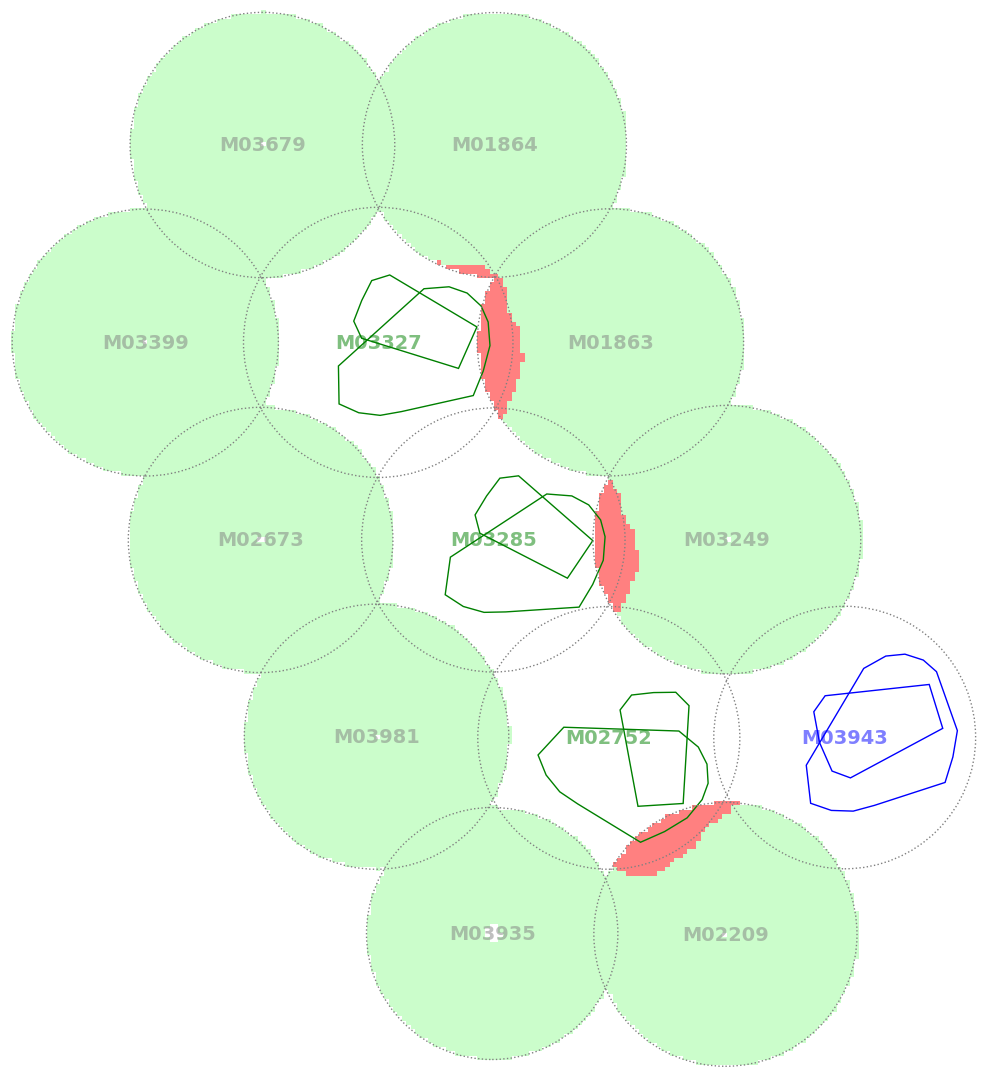

In [210]:
plotGroup(groups[3])

grid size: (401, 287) with 43511 reachable points
Using intT=-92.97, extP=48.16 for M04310
Using intT=-0.00, extP=180.00 for M04235
Using intT=127.03, extP=144.17 for M04309
Using intT=-11.01, extP=149.95 for M04507
Using intT=2.00, extP=149.84 for M03469
Using intT=-1.34, extP=149.83 for M04451
Using intT=-37.54, extP=153.59 for M04995
Using intT=36.00, extP=151.11 for M04519
Non-functional robots overlap with each other!
{'M04310': (-156.69702391828798, 48.16), 'M04235': (-75.3059170090613, 180.0), 'M04309': (161.9116647309238, 144.17), 'M04507': (-86.49637205278961, 149.95), 'M03469': (-137.81061714355883, 149.84), 'M04451': (144.34913704827912, 149.83), 'M04995': (-143.5575764862847, 153.59), 'M04519': (116.78166487048517, 151.11)}
[[False False False False False False False  True]
 [False False False False False False False False]
 [False False False False False False False False]
 [False False False False False False False False]
 [False False False False False False False False]

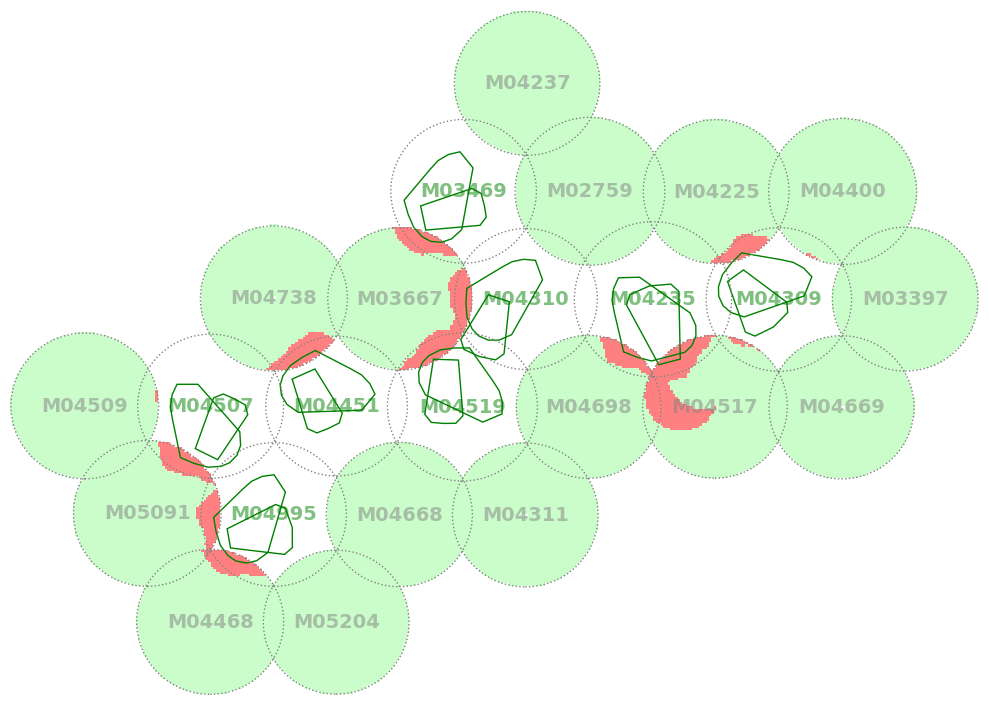

In [211]:
plotGroup(findGroup('M04310'), resetKeepouts=False)

### Optimization

In [219]:
def optimizeGroup(group, setP=160, dT=5, oversampling=25, verbose=False, plot=False):

    grid = initGrid(group, gridDensity=5, gridPad=6)
    angles, mapper, mask = getAngles(group, grid)
    if verbose:
        print(f'grid size: {grid.x.shape} with {mask.sum()} reachable points')

    # Get the current state of the non-functional robots in this group
    parkAngles = { }
    for posid in group.nonfunc:
        dev = lookup[posid]
        intT = dev['POS_T']
        extT = intT + dev['OFFSET_T']
        extP = np.round(dev['OFFSET_P'] + dev['POS_P'], 2)
        if verbose:
            print(f'Using intT={intT:.2f}, extP={extP:.2f} for {posid}')
        parkAngles[posid] = (extT, extP)

    # Calculate the initial score
    scores0 = getScores(grid, angles, mapper, parkAngles, resetKeepouts=False)
    if verbose:
        print(f'Initial score: nblocked {scores0.nblocked} ratio {100*scores0.ratio:.1f}%')

    # Calculate the score with reset keepouts for non-functional robots
    scores1 = getScores(grid, angles, mapper, parkAngles, resetKeepouts=True)
    if verbose:
        print(f'Reset keepouts: nblocked {scores1.nblocked} ratio {100*scores1.ratio:.1f}%')

    # Reset any extP < minP to setP
    any_tucked = False
    for posid in group.nonfunc:
        if posid in to_tuck:
            if verbose:
                print(f'Tucking {posid} to extP = {setP}')
            parkAngles[posid] = (parkAngles[posid][0], setP)
            any_tucked = True

    # Calculate scores with reset extP
    if any_tucked:
        scores2 = getScores(grid, angles, mapper, parkAngles, resetKeepouts=True)
        if verbose:
            print(f'Reset extP: nblocked {scores2.nblocked} ratio {100*scores2.ratio:.1f}%')
    else:
        scores2 = scores1

    # Find best extT to use for each parkable robot
    newT = { }
    # Define a coarse grid covering the full range of extT
    extTgrid = np.arange(-180, 180, dT)
    # Define a find grid of extToffset values relative to the coarse-grid minimum
    extToffset = np.linspace(-dT, dT, 2*oversampling+1)[1:-1]
    ratiogrid1 = np.zeros(extTgrid.shape)
    ratiogrid2 = np.zeros(extToffset.shape)
    for posid in group.parkable:
        dev = lookup[posid]
        minRatio = np.inf
        kbest = None
        # Loop over the coarse grid of extT values
        for k, extT in enumerate(extTgrid):
            parkAngles[posid] = (extT, parkAngles[posid][1])
            scores = getScores(grid, angles, mapper, parkAngles, resetKeepouts=True)
            ratiogrid1[k] = scores.ratio
            if (scores.ratio < minRatio) and not scores.fixedCollided:
                minRatio = scores.ratio
                kbest = k
        # Save the extT value to move to
        newT[posid] = extTgrid[kbest]
        if plot:
            plt.plot(extTgrid, ratiogrid1, '.-', label=posid)
            plt.axvline(extTgrid[kbest], color='r', ls='--')
            plt.show()
        # Loop over the fine grid of extToffset values
        minRatio = np.inf
        kbest2 = None
        for k, dextT in enumerate(extToffset):
            extT = newT[posid] + dextT
            parkAngles[posid] = (extT, parkAngles[posid][1])
            if dextT == 0:
                # Copy value from coarse scan
                ratiogrid2[k] = ratiogrid1[kbest]
            else:
                scores = getScores(grid, angles, mapper, parkAngles, resetKeepouts=True)
                ratiogrid2[k] = scores.ratio
            if (scores.ratio < minRatio) and not scores.fixedCollided:
                minRatio = scores.ratio
                kbest2 = k
        # Save the extT value to move to
        newT[posid] += extToffset[kbest2]
        if plot:
            plt.plot(extToffset, ratiogrid2, '.-', label=posid)
            plt.axvline(extToffset[kbest2], color='r', ls='--')
            plt.show()
        # Update the fixed position of this robot for optimizing subsequent robots
        parkAngles[posid] = (newT[posid], parkAngles[posid][1])
        if verbose:
            print(f'  {posid} moved to extT = {newT[posid]:.1f} with ratio {100*minRatio:.1f}%')

    return (scores0.ratio, scores1.ratio, scores2.ratio, minRatio), newT

In [204]:
def optimizeAll(groups, dT=5, progressInterval=10):

    scores = []
    allnewT = { }
    for i, group in enumerate(groups):
        ratios, newT = optimizeGroup(group, dT=dT)
        if ratios is None:
            print(f'Group {i} failed to optimize')
            continue
        scores.append(ratios)
        allnewT.update(newT)
        if (i+1) % progressInterval == 0:
            S = np.array(scores).sum(axis=0)
            print(f'Processed {i+1}/{len(groups)} groups: {np.round(S, 2)} -> {np.round(S[0]-S[1:], 2)}')

    print(f'Updated T for {len(allnewT)} parkable robots')

    S = np.array(scores).sum(axis=0)
    print(f' Initial score: {S[0]:.2f}')
    print(f'Reset keepouts: {S[1]:.2f} -> {S[0]-S[1]:.2f}')
    print(f'       Reset P: {S[2]:.2f} -> {S[0]-S[2]:.2f}')
    print(f'    Optimize T: {S[3]:.2f} -> {S[0]-S[3]:.2f}')

    return np.array(scores), allnewT

In [220]:
scores, newT = optimizeAll(groups)

Processed 10/383 groups: [2.33 2.27 1.72 0.34] -> [0.06 0.62 2.  ]
Processed 20/383 groups: [4.18 4.07 3.52 1.03] -> [0.1  0.66 3.15]
Processed 30/383 groups: [6.18 5.94 5.37 1.75] -> [0.24 0.8  4.43]
Processed 40/383 groups: [7.59 7.33 6.77 2.45] -> [0.25 0.82 5.14]
Processed 50/383 groups: [8.79 8.51 7.94 3.15] -> [0.28 0.85 5.64]
Processed 60/383 groups: [10.13  9.79  9.19  3.68] -> [0.33 0.94 6.45]
Non-functional robots overlap with each other!
{'M04310': (-156.69702391828798, 48.16), 'M04235': (-75.3059170090613, 180.0), 'M04309': (161.9116647309238, 144.17), 'M04507': (-86.49637205278961, 149.95), 'M03469': (-137.81061714355883, 149.84), 'M04451': (144.34913704827912, 149.83), 'M04995': (-143.5575764862847, 153.59), 'M04519': (116.78166487048517, 151.11)}
[[False False False False False False False  True]
 [False False False False False False False False]
 [False False False False False False False False]
 [False False False False False False False False]
 [False False False Fals

In [223]:
with open('results-0.2deg.json', 'w') as f:
    json.dump({
        'scores': scores.tolist(),
        'newT': newT
    }, f, indent=4)

In [292]:
with open('results-0.2deg.json') as f:
    data = json.load(f)
    scores = np.array(data['scores'])
    newT = data['newT']

### Generate Scripts

#### Move to Ranges

Output a CSV file to use with the new move_to_ranges PECS script:
```
python -m move_to_ranges --ranges_csv ValetParkTheta.csv -iter 10 --prepark None --mode poslocTP --anticollision None --verbose
```

In [294]:
def saveRangesSequence(newT, dT=0.5, filename='ValetParkTheta.csv'):

    rows = [ ]
    for pos_id in newT:
        dev = calib.loc[pos_id]
        extT = np.round(newT[pos_id], 3)
        rows.append(dict(
            POSID=pos_id,
            Theta_Lower_Limit=np.round(extT - dT,3),
            Theta_Upper_Limit=np.round(extT + dT),
            Phi_Lower_Limit='None',
            Phi_Upper_Limit='None',
        ))
    df = pd.DataFrame(rows)
    df.to_csv(filename, index=False)

saveRangesSequence(newT)

#### Run Sequence

Output a CSV file to use with [run_sequence](https://desi.lbl.gov/trac/browser/code/focalplane/plate_control/trunk/pecs/run_sequence.py):
```
python -m run_sequence \
  --infile valet-park.csv \
  --num_corr 5 \
  --anticollision None \
  --cycle_time 10 \
  --prepark None --postpark None
```

What is the CSV file format?  Will probably need to extract actual P values from the DB to use (and ensure only moving in T).

In [231]:
def saveSequence(newT, calib, filename='sequence.ecsv'):

    rows = [ ]
    for pos_id in newT:
        # Lookup the extP value to use
        intP = 0
        dev = calib.loc[pos_id]
        extP = np.round(intP + dev.offset_p, 3)
        extT = np.round(newT[pos_id], 3)
        # Save this move to the sequence
        rows.append(dict(
            move_idx=0, command='poslocTP',
            target0=extT, target1=extP,
            posids=pos_id, allow_corr=True,
            log_note='valet park'))

    meta = dict(
        creation_date=str(astropy.time.Time.now()),
    )
    T = astropy.table.Table(rows, meta=meta)
    T.write(filename, overwrite=True)

saveSequence(newT, calib, filename='sequence-20250410.ecsv')